In [40]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


### Set Parameters

In [41]:
SEED = 1234
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

NUM_FEATURES = 28*28
NUM_CLASSES = 10
GRAYSCALE = True

In [42]:
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


### Check the implementation here

https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html

In [43]:
def conv3x3(in_channels, out_channels, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None) -> None:
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True) # inplace=True means that it will modify the input directly, without allocating any additional output
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual # skip 
        out = self.relu(out)


        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1
        )
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            # initialize the weights
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="relu"
                )
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)

        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


### Accuracy

In [44]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100

In [45]:
from tqdm import tqdm

torch.manual_seed(SEED)

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
for epoch in tqdm(range(NUM_EPOCHS)):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()

        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
            
        model.eval()

with torch.set_grad_enabled(False): # save memory during inference
    print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))        

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.5395
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.1715
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.1552
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.1312
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1527
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1730
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.0570
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.0641
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1024
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0723


 10%|█         | 1/10 [08:16<1:14:29, 496.59s/it]

Epoch: 002/010 | Batch 0000/0469 | Cost: 0.0313
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0876
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0510
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0415
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.1683
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.0386
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0842
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.1842
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.0550
Epoch: 002/010 | Batch 0450/0469 | Cost: 0.0423


 20%|██        | 2/10 [16:20<1:05:12, 489.01s/it]

Epoch: 003/010 | Batch 0000/0469 | Cost: 0.4725
Epoch: 003/010 | Batch 0050/0469 | Cost: 0.0540
Epoch: 003/010 | Batch 0100/0469 | Cost: 0.0447
Epoch: 003/010 | Batch 0150/0469 | Cost: 0.0460
Epoch: 003/010 | Batch 0200/0469 | Cost: 0.0026
Epoch: 003/010 | Batch 0250/0469 | Cost: 0.0555
Epoch: 003/010 | Batch 0300/0469 | Cost: 0.0422
Epoch: 003/010 | Batch 0350/0469 | Cost: 0.0077
Epoch: 003/010 | Batch 0400/0469 | Cost: 0.0503
Epoch: 003/010 | Batch 0450/0469 | Cost: 0.0373


 30%|███       | 3/10 [24:15<56:19, 482.81s/it]  

Epoch: 004/010 | Batch 0000/0469 | Cost: 0.1782
Epoch: 004/010 | Batch 0050/0469 | Cost: 0.0081
Epoch: 004/010 | Batch 0100/0469 | Cost: 0.0423
Epoch: 004/010 | Batch 0150/0469 | Cost: 0.0288
Epoch: 004/010 | Batch 0200/0469 | Cost: 0.0048
Epoch: 004/010 | Batch 0250/0469 | Cost: 0.0694
Epoch: 004/010 | Batch 0300/0469 | Cost: 0.0885
Epoch: 004/010 | Batch 0350/0469 | Cost: 0.0533
Epoch: 004/010 | Batch 0400/0469 | Cost: 0.0596
Epoch: 004/010 | Batch 0450/0469 | Cost: 0.0799


 40%|████      | 4/10 [31:58<47:29, 474.91s/it]

Epoch: 005/010 | Batch 0000/0469 | Cost: 0.4053
Epoch: 005/010 | Batch 0050/0469 | Cost: 0.0365
Epoch: 005/010 | Batch 0100/0469 | Cost: 0.0454
Epoch: 005/010 | Batch 0150/0469 | Cost: 0.0069
Epoch: 005/010 | Batch 0200/0469 | Cost: 0.0248
Epoch: 005/010 | Batch 0250/0469 | Cost: 0.0372
Epoch: 005/010 | Batch 0300/0469 | Cost: 0.0391
Epoch: 005/010 | Batch 0350/0469 | Cost: 0.0314
Epoch: 005/010 | Batch 0400/0469 | Cost: 0.0050
Epoch: 005/010 | Batch 0450/0469 | Cost: 0.0160


 50%|█████     | 5/10 [39:25<38:45, 465.00s/it]

Epoch: 006/010 | Batch 0000/0469 | Cost: 0.5787
Epoch: 006/010 | Batch 0050/0469 | Cost: 0.0133
Epoch: 006/010 | Batch 0100/0469 | Cost: 0.1367
Epoch: 006/010 | Batch 0150/0469 | Cost: 0.0391
Epoch: 006/010 | Batch 0200/0469 | Cost: 0.0022
Epoch: 006/010 | Batch 0250/0469 | Cost: 0.0092
Epoch: 006/010 | Batch 0300/0469 | Cost: 0.0009
Epoch: 006/010 | Batch 0350/0469 | Cost: 0.0629
Epoch: 006/010 | Batch 0400/0469 | Cost: 0.0131
Epoch: 006/010 | Batch 0450/0469 | Cost: 0.0240


 60%|██████    | 6/10 [47:03<30:49, 462.44s/it]

Epoch: 007/010 | Batch 0000/0469 | Cost: 0.8569
Epoch: 007/010 | Batch 0050/0469 | Cost: 0.0041
Epoch: 007/010 | Batch 0100/0469 | Cost: 0.0441
Epoch: 007/010 | Batch 0150/0469 | Cost: 0.0049
Epoch: 007/010 | Batch 0200/0469 | Cost: 0.0504
Epoch: 007/010 | Batch 0250/0469 | Cost: 0.0120
Epoch: 007/010 | Batch 0300/0469 | Cost: 0.0468
Epoch: 007/010 | Batch 0350/0469 | Cost: 0.0361
Epoch: 007/010 | Batch 0400/0469 | Cost: 0.0084
Epoch: 007/010 | Batch 0450/0469 | Cost: 0.0200


 70%|███████   | 7/10 [54:41<23:02, 460.85s/it]

Epoch: 008/010 | Batch 0000/0469 | Cost: 0.3967
Epoch: 008/010 | Batch 0050/0469 | Cost: 0.0146
Epoch: 008/010 | Batch 0100/0469 | Cost: 0.0276
Epoch: 008/010 | Batch 0150/0469 | Cost: 0.0006
Epoch: 008/010 | Batch 0200/0469 | Cost: 0.0040
Epoch: 008/010 | Batch 0250/0469 | Cost: 0.0036
Epoch: 008/010 | Batch 0300/0469 | Cost: 0.0048
Epoch: 008/010 | Batch 0350/0469 | Cost: 0.0222
Epoch: 008/010 | Batch 0400/0469 | Cost: 0.0056
Epoch: 008/010 | Batch 0450/0469 | Cost: 0.0021


 80%|████████  | 8/10 [1:02:17<15:18, 459.43s/it]

Epoch: 009/010 | Batch 0000/0469 | Cost: 0.3907
Epoch: 009/010 | Batch 0050/0469 | Cost: 0.0071
Epoch: 009/010 | Batch 0100/0469 | Cost: 0.1077
Epoch: 009/010 | Batch 0150/0469 | Cost: 0.0003
Epoch: 009/010 | Batch 0200/0469 | Cost: 0.0043
Epoch: 009/010 | Batch 0250/0469 | Cost: 0.0238
Epoch: 009/010 | Batch 0300/0469 | Cost: 0.0383
Epoch: 009/010 | Batch 0350/0469 | Cost: 0.0135
Epoch: 009/010 | Batch 0400/0469 | Cost: 0.0034
Epoch: 009/010 | Batch 0450/0469 | Cost: 0.0319


 90%|█████████ | 9/10 [1:10:04<07:41, 461.77s/it]

Epoch: 010/010 | Batch 0000/0469 | Cost: 1.7708
Epoch: 010/010 | Batch 0050/0469 | Cost: 0.0116
Epoch: 010/010 | Batch 0100/0469 | Cost: 0.0332
Epoch: 010/010 | Batch 0150/0469 | Cost: 0.0010
Epoch: 010/010 | Batch 0200/0469 | Cost: 0.0042
Epoch: 010/010 | Batch 0250/0469 | Cost: 0.0551
Epoch: 010/010 | Batch 0300/0469 | Cost: 0.0059
Epoch: 010/010 | Batch 0350/0469 | Cost: 0.0019
Epoch: 010/010 | Batch 0400/0469 | Cost: 0.0015
Epoch: 010/010 | Batch 0450/0469 | Cost: 0.0352


100%|██████████| 10/10 [1:17:54<00:00, 467.41s/it]


Epoch: 010/010 | Train: 99.227%
Time elapsed: 82.37 min
Total Training Time: 82.38 min


# Evaluate the model

In [46]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.77%


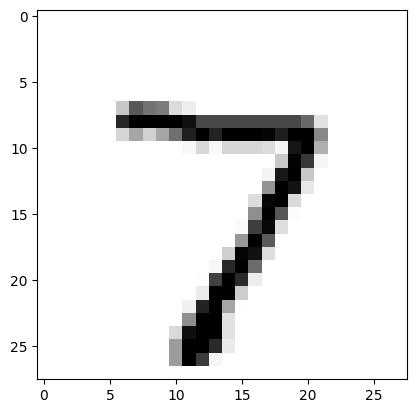

In [47]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')

In [48]:
model.eval()
logit, probas = model(features.to(DEVICE)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%
